# Kaggle Titanic survival - TensorFlow extra functionality

In this example we show extra TensorFlow/Keras functionality, inlcuding

* Changing class weights, e.g. to increase weight of minroty class(es)
* Saving model checkpoints while training (and only saving models with improved validation accuracy)
* Early stop of model (when no improvement)
* Getting model weights
* Saving and reloading model

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Download data if not previously downloaded

In [3]:
download_required = False

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

Here we use the api-based method to set up a TensorFlow neural network. This method allows us
to more flexibly define the inputs for each layer, rather than assuming there is a simple sequence as with the Sequential method.

We will put construction of the neural net into a separate function.

The neural net is a relatively simple network. The inputs are connected to two hidden layers (of 240 and 50 nodes) before being connected to two output nodes corresponding to each class (died and survived). It also contains some useful additions (batch normalisation and dropout) as described below.
The layers of the network are:

1) An input layer (which does need to be defined)

2) A fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of outputs. We will expand out feature data set up to 240 outputs. The output of the layer uses ReLU (rectified linear unit) activation. ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.

3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). The layer definition includes the number of inputs to normalise. 

4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.3 outputs are set to zero (p=0.1 means 10% of outputs are set to zero).

5) A second fully connected layer which reduces the network down to 50 nodes. This again uses ReLU activation and is followed by batch normalisation, and dropout layers.

6) A final fully connected linear layer of one nodes (more nodes could be used for more classes, in which case use softmax activation and categorical_crossentropy in the loss function). The output of the net is the probability of surviving (usually a probability of >= 0.5 will be classes as ‘survived’).

In [6]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    inputs = layers.Input(shape=number_features)
    dense_1 = layers.Dense(240, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(0.25)(norm_1)
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    outputs = layers.Dense(1, activation='sigmoid')(dense_2)
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

## Show summary of the model structure

Here we will create a model with 10 input features and show the structure of the model as  atable and as a graph.

In [7]:
model = make_net(10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 240)               2640      
_________________________________________________________________
batch_normalization (BatchNo (None, 240)               960       
_________________________________________________________________
dropout (Dropout)            (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,701
Trainable params: 15,221
Non-trainable params: 480
_______________________________________________________

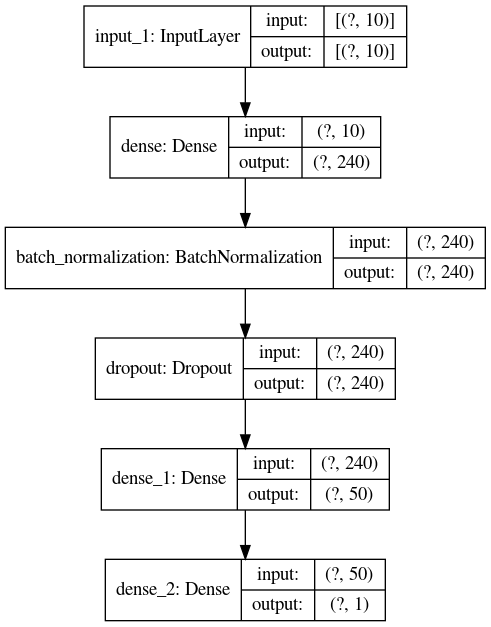

In [8]:
# If necessary pip or conda install pydot and graphviz
keras.utils.plot_model(model, "titanic_tf_model.png", show_shapes=True)

## Set dictionary of weights according to class distribution

Here we will create a dictionary of class weights, in inverse proportion to how frequently a class occurs (to less frequent classes will be given more weight in model).

In [9]:
# Get proportion of each class
prop_class_1 = y.mean()
prop_class_0 = 1 - prop_class_1

# Set weights in inverse propotion to occurance
weight_class_0 = 1 / prop_class_0
weight_class_1 = 1 / prop_class_1

# Create dictionary of class weight
class_weights = {0: weight_class_0, 1: weight_class_1}

## Train model

TensorFlow can track the history of training, enabling us to examine performance against training and test sets over time. Here we will use the same model as above, but without k-fold validation and with history tracking.

In [10]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25)

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features)

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs)
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25,
                                                  restore_best_weights=True)

# Train model (including class weights)
history = model.fit(X_train_sc,
                    y_train,
                    class_weight = class_weights,
                    epochs=250,
                    batch_size=512,
                    validation_data=(X_test_sc, y_test),
                    verbose=0,
                    callbacks=[checkpoint_cb, early_stopping_cb])

# Custom callbacks may also be defined. 
# These may run on training start/end, on epoch start/end, or bacth start/end.
# For more on callbacks, see: https://keras.io/callbacks/

# Reload model with model = keras.models.load_model('model_name.h5')

`history` is a dictionary containing data collected during training. Let's take a look at the keys in this dictionary (these are the metrics monitored during training):

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot training history:

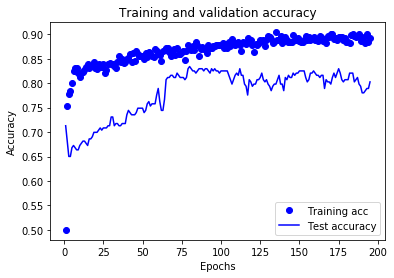

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Getting model weights

Here we show how weights for a layer can be extracted from the model if required.

In [13]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [14]:
weights, biases = hidden1.get_weights() # Biases are not used in this model
weights.shape

(24, 240)

In [15]:
weights

array([[ 0.09831878,  0.00095421, -0.0315306 , ...,  0.04338021,
        -0.06361132, -0.11998222],
       [-0.14860605, -0.14321715, -0.21729669, ..., -0.10497281,
        -0.00544671,  0.08742972],
       [ 0.19444685, -0.25497147, -0.26355544, ..., -0.04473477,
        -0.01675704, -0.08084001],
       ...,
       [ 0.00503647,  0.09600063,  0.16502336, ..., -0.0479717 ,
        -0.04364294, -0.01065058],
       [ 0.13185853,  0.0442397 ,  0.28435254, ..., -0.10624892,
        -0.06891162, -0.05097416],
       [-0.07428776, -0.08290047, -0.00235088, ..., -0.03209899,
         0.11206697, -0.02455206]], dtype=float32)

## Saving and reloading model

In [16]:
# Save model
model.save('titanic_tf_model.h5')

# Load and use saved model
restored_model = keras.models.load_model('titanic_tf_model.h5')
 
# Predict classes
predicted_proba = restored_model.predict(X_test_sc)

In [17]:
predicted_proba[:10]

array([[0.08830598],
       [0.41938564],
       [0.221618  ],
       [0.221618  ],
       [0.6683974 ],
       [0.66384685],
       [0.12354884],
       [0.20096537],
       [0.42112043],
       [0.22299322]], dtype=float32)